<a href="https://colab.research.google.com/github/zhe0/prac/blob/main/Bertopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### task: 主題分析、脈絡/框架/議題
##### issue: 或許可找雜訊，主要是外訓有教過就放上來
##### method: BERTopic、distiluse-base-multilingual-cased-v1、sbert/sentence_transformers
##### note:
* 主題分析加上sentence transformers
* 因為使用中文語料，要斷詞，必須額外確定有中文的sbert以及停用字
* 看是否需要pyldavis做display
* [BERTopic](https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html#keybert-bertopic)
* [sbert](https://www.sbert.net/index.html)

#### 重點前提
* 可以不用指定主題數!!!
* bertopic混合分群、降維、主題分析、tdidf
* 後續圖表有主題機率二維分布圖、降維二維的文章群聚圖(hdbscan and umap)、主題機率時間分析、分類型/屬性的主題機率分布
    * 文章群聚圖:群中心的文章有哪些?離群文章有哪些?
    * 主題在時間比例:觀察主題在不同時間上的比重
    * 主題在分類比例:觀察主題在不同類別上的比重
* 可強化措施
    * 精耕stop word、同義字、剃除雜訊
    * 試試其他embedding
* 加速用，一般colab使用指定device為cuda，請記得開啟colab的ＧＰＵ
    * 執行階段 -> 變更執行階段類型
* 可參考的pretrained model of [sentenceBert](https://www.sbert.net/docs/pretrained_models.html#multi-lingual-models)。找到適合pretrained model請修改sent變數

#### 文本來源
* tvbs, ettoday, ebc, 自由, 聯合 關於維吾爾與新疆新聞文章

In [ ]:
# 建議登入google，存檔你的模組檔
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture

# 安裝這些套件
!pip install torch umap-learn scikit-learn bertopic zhon --upgrade
!wget https://github.com/thumbb13555/PDFMakerExample/raw/master/app/src/main/assets/kaiu.ttf
# 下載資料檔(已pickled pandas file)
!gdown 1_ZtZC-r-seNZ7xh5kg5ajdIb3RfH1tLG #combine_tag
# import packages
import re, pickle, os, torch
import numpy as np
import pandas as pd
import multiprocessing as mp
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
# import locale #如果發生shell指令不能用的話
# locale.getpreferredencoding = lambda: "UTF-8"

# 偵測一下有無GPU
device='cpu'
if torch.cuda.is_available():
    device='cuda'
elif torch.backends.mps.is_available():
    device='mps'
torch.set_num_threads(mp.cpu_count())

# 一些functions
def pkl(path,wbORrb,datas=None):
    '''
    datas:tuples of your data
    wbORr:string only wb or rb
    '''
    if not (wbORrb == 'wb' or wbORrb == 'rb'):
        return None
    if wbORrb == 'rb' and not os.path.exists(path) and datas is not None:
        return None
    try:
        with open(path,wbORrb) as f:
            if wbORrb == 'wb':
                pickle.dump(datas,f)
                return True
            else:
                return pickle.load(f)
    except Exception as e:
        print('pickle error:', e)
        return False

# 重要變數
sent='distiluse-base-multilingual-cased-v1'
path='/content/drive/MyDrive/school/after/維吾爾/combine_tag.pkl'
# path='/content/combine_shrink.pkl'
d,stops=pkl(path,'rb')
d=pd.DataFrame(d)

#### bertopic所需兩資料:如下面cell pandas結果所示，content欄是list of 中文書寫string 以及tok_stopped_str欄是list of 英文書寫string
* docs: 英文書寫形式，為tfidf使用，bottom-up建構主題詞彙
* embeddings: 中文書寫形式為，top-down文章的embedding/representation/hidden unit做分群

In [ ]:
# 設定變數
print('your device:',device ,f' and cpu {mp.cpu_count()} cores')
print('文本總量',len(d))

timestamps=d['time'].tolist()
docs=d['tok_stopped_str'].tolist()
sentences=d['content'].tolist()
titles_docs=d['title_tok_stopped_str'].tolist()
titles=d['title'].tolist()
classes=d['media'].tolist()

# 2017後各家報紙數
print(d['media'].value_counts())
# 聲量分析
d

your device: cuda  and cpu 2 cores
文本總量 14637
ltn        7361
ETtoday    3530
udn        2096
TVBS        957
EBC         693
Name: media, dtype: int64


,media,title,content,time,tok_stopped_str,time_over,tok,pos,tok_stopped,adj_adv,noun,verb,title_tok,title_pos,title_tok_stopped,title_tok_stopped_str
0,TVBS,迪麗熱巴、肖戰甜蜜現身機場？狗仔爆料遭揭P圖 粉絲怒了,"30歲大陸維吾爾族女星迪麗熱巴,以甜美不做作個性深得粉絲喜愛,不僅戲劇以及綜藝節目表現亮眼,...",2023/01/04 08:21,"30 歲 大陸 維吾爾族 女星 迪麗熱巴 , 以 甜美 不 做作 個性 深得 粉絲 喜愛 ,...",1,"[30, 歲, 大陸, 維吾爾族, 女星, 迪麗熱巴, ,, 以, 甜美, 不, 做作, 個...","[CD, M, NN, NN, NN, NR, PU, P, VA, AD, VV, NN,...","[30, 歲, 大陸, 維吾爾族, 女星, 迪麗熱巴, ,, 以, 甜美, 不, 做作, 個...","[甜美, 不, 不僅, 亮眼, 還, 未料, 卻, 甜蜜, 很, 快, 就, 全, 吃瓜, ...","[大陸, 維吾爾族, 女星, 迪麗熱巴, 個性, 粉絲, 喜愛, 戲劇, 綜藝, 節目, 表...","[做作, 深得, 獲獎, 遭, 爆料, 約會, 引起, 值得, 抓包, 推翻, 自導, 自演...","[迪麗熱巴, 、, 肖戰, 甜蜜, 現身, 機場, ？, 狗仔, 爆料, 遭, 揭, P, ...","[NR, PU, NR, NN, VV, NN, PU, NN, NN, VV, VV, N...","[迪麗熱巴, 、, 肖戰, 甜蜜, 現身, 機場, ？, 狗仔, 爆料, 遭, 揭, P, ...",迪麗熱巴 肖戰 甜蜜 現身 機場 狗仔 爆料 遭 揭 P 圖 粉絲 怒 了
1,TVBS,中共為何會殘暴監控新疆維吾爾族人？ 竟與「藏族」有關,"達賴喇嘛的紀錄電影《夢迴西藏:軍官與達賴喇嘛》,除了揭穿他當年率領8萬藏民流亡印度的驚滔駭浪...",2022/12/09 21:17,"達賴 喇嘛 的 紀錄 電影 《 夢迴 西藏 : 軍官 與 達賴 喇嘛 》 , 除了 揭穿 他...",1,"[達賴, 喇嘛, 的, 紀錄, 電影, 《, 夢迴, 西藏, :, 軍官, 與, 達賴, 喇...","[NR, NN, DEG, NN, NN, PU, VV, NR, PU, NN, CC, ...","[達賴, 喇嘛, 的, 紀錄, 電影, 《, 夢迴, 西藏, :, 軍官, 與, 達賴, 喇...","[驚滔駭浪, 前, 更, 廣, 而, 更, 更, 多, 推新, 將, 卻, 未, 均, 從此...","[達賴, 喇嘛, 紀錄, 電影, 西藏, 軍官, 達賴, 喇嘛, 當年, 藏民, 印度, 真...","[夢迴, 揭穿, 率領, 流亡, 護送, 令, 震驚, 夢迴, 揭露, 設, 阻止, 逃往,...","[中共, 為何, 會, 殘暴, 監控, 新疆, 維吾爾族人, ？, 竟, 與, 「, 藏族,...","[NR, AD, VV, AD, VV, NR, NN, PU, AD, P, PU, NN...","[中共, 為何, 會, 殘暴, 監控, 新疆, 維吾爾族人, ？, 竟, 與, 「, 藏族,...",中共 為何 會 殘暴 監控 新疆 維吾爾族人 竟 與 藏族 有關
2,TVBS,英調查點名多家國際車廠 供應鏈恐涉新疆強迫勞動,"英國雪菲爾哈倫大學團隊耗時6個月調查發現,西方汽車大廠與中國新疆地區的維吾爾少數民族侵犯人權...",2022/12/08 13:43,"英國 雪菲爾哈倫 大學 團隊 耗時 6 個 月 調查 發現 , 西方 汽車 大 廠 與 中國...",1,"[英國, 雪菲爾哈倫, 大學, 團隊, 耗時, 6, 個, 月, 調查, 發現, ,, 西方...","[NR, NR, NN, NN, VV, CD, M, NN, VV, VV, PU, NN...","[英國, 雪菲爾哈倫, 大學, 團隊, 耗時, 6, 個, 月, 調查, 發現, ,, 西方...","[大, 少數, 巨大, 持續, 知名, 匿名, 刻意, 就, 被迫, 還, 公開, 巨大, ...","[英國, 雪菲爾哈倫, 大學, 團隊, 月, 西方, 汽車, 廠, 中國, 新疆, 地區, ...","[耗時, 調查, 發現, 侵犯, 存在, 擴大, 點名, 報導, 位, 調查, 發現, 受制...","[英, 調查, 點名, 多, 家, 國際, 車廠, 供應鏈, 恐, 涉, 新疆, 強迫, 勞動]","[NR, VV, VV, CD, M, NN, NN, NN, AD, VV, NR, JJ...","[英, 調查, 點名, 多, 家, 國際, 車廠, 供應鏈, 恐, 涉, 新疆, 強迫, 勞動]",英 調查 點名 多 家 國際 車廠 供應鏈 恐 涉 新疆 強迫 勞動
3,TVBS,「白紙革命」續燒海外！ 土耳其維族人燒習近平像,"「白紙革命」在大陸風波暫歇,然而海外的聲援抗議,正接力登場。包括日本、南韓、美國到歐洲,都有...",2022/12/01 22:25,"「 白紙 革命 」 在 大陸 風波 暫歇 , 然而 海外 的 聲援 抗議 , 正 接力 登場...",1,"[「, 白紙, 革命, 」, 在, 大陸, 風波, 暫歇, ,, 然而, 海外, 的, 聲援...","[PU, NN, NN, PU, P, NN, NN, VV, PU, AD, NN, DE...","[「, 白紙, 革命, 」, 在, 大陸, 風波, 暫歇, ,, 然而, 海外, 的, 聲援...","[然而, 正, 接力, 都, 大多, 不, 慷慨, 激昂, 也, 就, 就, 不, 自由, ...","[白紙, 革命, 大陸, 風波, 海外, 聲援, 抗議, 日本, 南韓, 美國, 歐洲, 華...","[暫歇, 登場, 包括, 到, 現身, 抗議, 要求, 下台, 焚燒, 洩憤, 抗爭, 擴散...","[「, 白紙, 革命, 」, 續, 燒, 海外, ！, 土耳其, 維族人, 燒, 習近平, 像]","[PU, NN, NN, PU, VV, VV, NN, PU, NR, NN, VV, N...","[「, 白紙, 革命, 」, 續, 燒, 海外, ！, 土耳其, 維族人, 燒, 習近平, 像]",白紙 革命 續 燒 海外 土耳其 維族人 燒 習近平 像
4,TVBS,跨族裔支持白紙運動 華府中國使館外嗆中共下台,"反封控「白紙運動」蔓延海外,旅美中國人、維吾爾人與台灣人團結不分你我,今天分頭在華府中國駐美...",2022/12/01 14:45,"反 封控 「 白紙 運動 」 蔓延 海外 , 旅美 中國人 、 維吾爾人 與 台灣人 團結 ...",1,"[反, 封控, 「, 白紙, 運動, 」, 蔓延, 海外, ,, 旅美, 中國人, 、, 維...","[VV, NN, PU, NN, NN, PU, VV, NN, PU, JJ, NN, P...","[反, 封控, 「, 白紙, 運動, 」, 蔓延, 海外, ,, 旅美, 中國人, 、, 維...","[旅美, 不, 駐美, 高, 駐美, 高, 已, 則, 但, 最終, 都, 旅美, 在一塊,...","[封控, 白紙, 運動, 海外, 中國人, 維吾爾人, 台灣人, 今天, 華府, 中國, 大...","[反, 蔓延, 團結, 分, 分頭, 聲援, 抗爭, 喊, 下台, 下台, 頂, 聚集, 位...","[跨族裔, 支持, 白紙, 運動, 華府, 中國, 使館, 外, 嗆, 中共, 下台]","[NN, VV, NN, NN, NR, NR, NN, LC, VV, NR, VV]","[跨族裔, 支持, 白紙, 運動, 華府, 中國, 使館, 外, 嗆, 中共, 下台]",跨族裔 支持 白紙 運動 華府 中國 使館 外 嗆 中共 下台
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18042,udn,烏魯木齊（新疆） 棉花去年產量265萬噸 連22年稱冠大陸,"新疆維吾爾自治區農業工作會議指出,2016年新疆棉花播種面積達2,348萬畝,總產量265....",2017-03-02,"新疆 維吾爾 自治區 農業 工作 會議 指出 , 2016年 新疆 棉花 播種 面積 達 2...",1,"[新疆, 維吾爾, 自治區, 農業, 工作, 會議, 指出, ,, 2016年, 新疆, 棉...","[NR, NR, NN, NN, NN, NN, VV, PU, NT, NR, NN, N...","[新疆, 維吾爾, 自治區, 農業, 工作, 會議, 指出, ,, 2016年, 新疆, 棉...","[總, 連續, 將, 優質]","[新疆, 維吾爾, 自治區, 農業, 工作, 會議, 2016年, 新疆, 棉花, 播種, ...","[指出, 達, 位居, 續, 鞏固]","[烏魯木齊, （, 新疆, ）, 棉花, 去年, 產量, 265萬, 噸, 連, 22, 年...","[NR, PU, NR, PU, NN, NT, NN, CD, M, AD, CD, M,...","[烏魯木齊, （, 新疆

In [ ]:
# 舊程式碼，處理title標題去掉停用字
# import string
# import zhon
# punct = list(string.punctuation) # python punctuations
# punct=punct+['©', '^', '®',' ','¾', '¡','!']
# punct=punct+[i for i in zhon.hanzi.punctuation]
# d['title_tok_stopped_str']=d['title_tok_stopped_str'].apply(lambda x:[i for i in x if i not in punct])
# d['title_tok_stopped_str']=d['title_tok_stopped_str'].apply(lambda x:' '.join(x))
# path='/content/drive/MyDrive/school/after/維吾爾/combine_tag.pkl'
# pkl(path,'wb',datas=(d,stops))
# d['title_tok_stopped_str']

True

### 建立兩個model，以下p參數可以試試
* normalize_embeddings=True 若樣本量有接近母數可用
* batch_size 若有獨顯可以自由加大，colab就差不多
* low_memory 記憶體不夠請True
* top_n_words 建議放大，上限30
* n_gram_range 若trigram，在後面定義主題意義時發現沒三字，建議回bi

In [ ]:
# paragraph embedding
sentence_model = SentenceTransformer(sent,device=device)
p={'sentences':docs, 'show_progress_bar':False,'device':device,'normalize_embeddings':True,'batch_size':1024}
embeddings = sentence_model.encode(**p)
# diversity有助於拉開主題間距哩，但不建議使用，0-1，1拉最開
# low_memory:True有效降低mem使用，但速度會慢
# n_gram_range:基本使用是(1,1)，越多參考越多連續字詞(我使用bi-gram)、trigram用過後沒發現好處
p={'low_memory':False, 'top_n_words': 30,'calculate_probabilities':True, 'verbose':True,
   'n_gram_range':(1,1),'language':'multilingual'}#'embedding_model':sent
topic_model = BERTopic(**p)

In [ ]:
# fit_transform dataset
# topics, probs = topic_model.fit_transform(docs,embeddings)
topics, probs = topic_model.fit_transform(titles_docs,embeddings)

2023-04-12 13:45:45,693 - BERTopic - Reduced dimensionality
2023-04-12 13:46:09,466 - BERTopic - Clustered reduced embeddings


In [ ]:
# 儲存與讀取model
pre=r'/content/drive/MyDrive/school/after/維吾爾/' #請自改
# pre=r'/content/'
mdl_path=pre+'uyghur_topic_mdl'#'uyghur_title_topic_mdl'
# topic_model.save(mdl_path) #請小心
topic_model = BERTopic.load(mdl_path)
len('目前主題數',topic_model.topic_sizes_) #主題數

209

In [ ]:
# build時間分析用的model
topics_over_time = topic_model.topics_over_time(titles_docs, timestamps=timestamps)

3730it [15:25,  4.03it/s]


In [ ]:
# 儲存與讀取time model
mdl_time_path=pre+'uyghur_title_topic_time.pd'
pkl(mdl_time_path,'wb',datas=topics_over_time)

True

#### 右側主題可以互動，點擊後可以選擇或不選擇，觀察主題的時間變化，也可觀察主題內的用詞
* topics 以list:int為element，指定你要show的主題。topic_model.topic_sizes_就全部都show
* normalize_frequency 好像沒效...? 建議先給False

In [ ]:
p={'topics_over_time':topics_over_time,'normalize_frequency':False,
   'topics':[i for i in range(7+1)]+[-1],}
topic_model.visualize_topics_over_time(**p)

### 主觀賦予主題意義
* 針對某主題的topN關鍵字， topN數量取決於top_n_words，無法在多

In [ ]:
topic_model.get_topic(7)

[('廣場', 0.1991200504582925),
 ('自由', 0.10356375644747372),
 ('時評', 0.03416171181271164),
 ('青年', 0.03211165660423023),
 ('國民黨', 0.018494802777791874),
 ('金恒煒', 0.01581070499758491),
 ('鏗鏘集', 0.014078628140944615),
 ('專欄', 0.013782408657199449),
 ('台灣', 0.01368839591482296),
 ('重奪', 0.010096757204444808),
 ('李筱峰', 0.010096757204444808),
 ('年輕人', 0.009712715756789775),
 ('失敗主義', 0.009385752093963078),
 ('保衛', 0.009385752093963078),
 ('老大', 0.009385752093963078),
 ('抉擇', 0.008882106902840825),
 ('習近平', 0.008534260732469746),
 ('民主', 0.008512466687067533),
 ('公開信', 0.00817392086190035),
 ('一邊', 0.00817392086190035),
 ('軍人', 0.00817392086190035),
 ('出路', 0.007905352498792454),
 ('憲法', 0.007905352498792454),
 ('現象', 0.007905352498792454),
 ('時代', 0.007585007320808911),
 ('戰爭', 0.007585007320808911),
 ('敵人', 0.007285847619082526),
 ('反共', 0.007285847619082526),
 ('人民', 0.007157272805922906),
 ('和平', 0.0071356093690993294)]

In [ ]:
# 僅是用圖例展示斷詞站主題的機率，幫助主觀賦以主題意義。前5主題的斷詞分佈
topic_model.visualize_barchart([i for i in range(10)])

In [ ]:
# 若不好猜回主題，可看主題在模組建立時，參考哪三篇文章最貼近
# 假設我看不懂第一個主題
topic_idx=3
[i for i in topic_model.get_representative_docs(topic_idx)[:3]] #只取第一二三篇

['華郵 ： 美 擬 外交 抵制 北京 冬奧', '美 本 週 宣布 外交 抵制 北京 冬奧', '美 宣布 外交 抵制 北京 冬奧']

In [ ]:
# qry給關鍵字，若關鍵字全中的文章秀出10篇。幫忙一下回找重點字詞的文章
qry=['國務院','眾議院']
idx=[i for i in range(len(titles_docs)) if all([True if j in titles_docs[i] else False for j in qry])][:10]
d.iloc[idx][['content']]

,content


### 用途:你觀察到有興趣的文章，可能是群中心、可能是離群文章、可能是你注重的長報導、可能是注重的高轉發高討論高按讚帖子
* approximate_distribution、approximate_distribution執行一次就好
* 文章順序，改idx當參數

In [ ]:
topic_distr, _ = topic_model.approximate_distribution(titles_docs) #角度是documental embedding
topic_token_distr, token_distr = topic_model.approximate_distribution(titles_docs, calculate_tokens=True)
topic_token_distr.shape,topic_distr.shape #這matrix代表說，(文章或斷詞)對應主題機率組合，單篇文章(內的文章或斷詞)加總必為百。

100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


((14637, 208), (14637, 208))

In [ ]:
doc_idx=192
topic_model.visualize_distribution(topic_distr[doc_idx]) #該篇文章的主題機率組合

In [ ]:
# 看看第十篇文章是因為那些字詞被分到這12個主題
doc_idx=192
df = topic_model.visualize_approximate_distribution(titles_docs[doc_idx], token_distr[doc_idx])
df

,花木蘭,挨轟,間接,迫害,維族,高層,拍攝,紐西蘭
29_花木蘭_迪士尼_票房_片尾,0.159,0.159,0.159,0.159,0.000,0.000,0.000,0.000
71_紐西蘭_紐西蘭 總理_總理_紐國,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104


In [ ]:
# 用途1.看相對位置與圓大小，確認training效果好不好。
# 用途2.建議主題數要少才會有對比效果，或直接指定某幾個主題看看距離，但只是看個感覺...
topic_model.visualize_topics()

### 資料內有分類屬性的話，可試試。用途於不同分類的主題量(累積主題機率)差別
* topics 選擇你要比較的主題

In [ ]:
topics_per_class = topic_model.topics_per_class(titles_docs, classes=classes)

5it [00:02,  2.46it/s]


In [ ]:
# 儲存與讀取cls model
mdl_cls_path=pre+'uyghur_title_topic_cls.pd'
pkl(mdl_cls_path,'wb',datas=topics_per_class)

True

In [ ]:
topic_model.visualize_topics_per_class(topics_per_class,topics=[i for i in range(5)])

### 觀察主題內的動詞?名詞?形容詞?有哪些

In [ ]:
# 使用文字雲與POS之前的計算
from wordcloud import WordCloud
from collections import Counter # 次數統計

pos={
    'verb':{i:{} for i in range(topic_distr.shape[1])},
    'adj':{i:{} for i in range(topic_distr.shape[1])},
    'noun':{i:{} for i in range(topic_distr.shape[1])},
     }

for i in range(len(docs)):
    for j in range(topic_distr.shape[1]):
        ratio=topic_distr[i,j]
        if ratio<=0:continue
        v=Counter(d['verb'].iloc[i])
        n=Counter(d['noun'].iloc[i])
        a=Counter(d['adj_adv'].iloc[i])
        v={k:v[k]*2 for k in v}
        n={k:n[k]*2 for k in n}
        a={k:a[k]*2 for k in a}
        pos['verb'][j].update(v)
        pos['noun'][j].update(n)
        pos['adj'][j].update(a)

params={'background_color':"rgba(255, 255, 255, 0)",'mode':"RGBA",
        'max_font_size':None, 'font_path':'./kaiu.ttf'}
# font_step=1

pos:verb topics:0


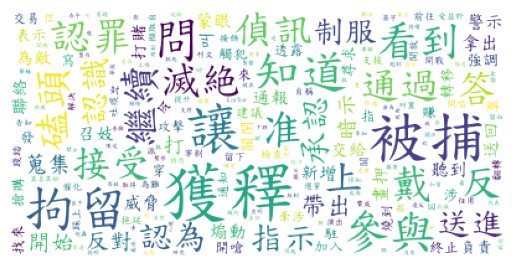

pos:noun topics:0


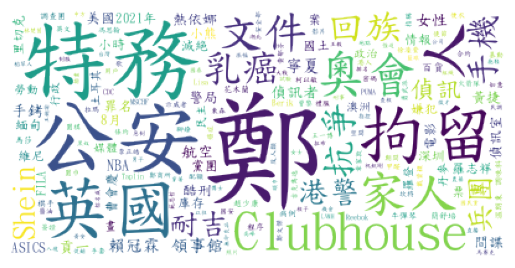

pos:verb topics:7


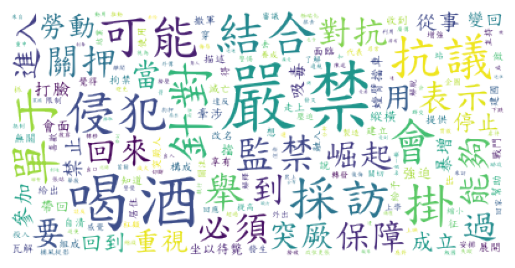

pos:noun topics:7


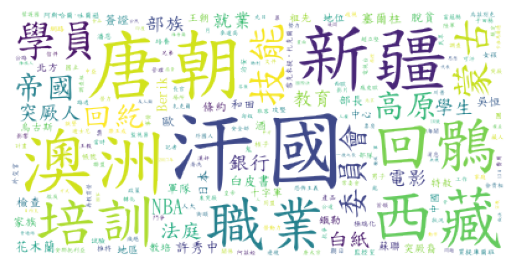

In [ ]:
p=['verb','noun'] #想看verb與noun
topic_idx=[0,7] #假如我想看主題0(新疆棉)與主題7(教育營)
for i in topic_idx:
    for j in p:
        print(f'pos:{j} topics:{i}')
        plt.axis('off')
        plt.imshow(WordCloud(**params).generate_from_frequencies(pos[j][i]))
        plt.show()

### 將斷詞慢慢分階層，觀察字詞如何細分到各個主題，有幫助於建立抽象的大主題

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(titles_docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

  0%|          | 0/207 [00:00<?, ?it/s]


AttributeError: ignored

In [ ]:
#  Print topic tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─確診_本土_新增_病例_肺炎
│    ├─確診_本土_新增_疫情_病例
│    │    ├─■──內蒙古_本土_確診_滿洲里_75 ── Topic: 105
│    │    └─確診_本土_新增_疫情_病例
│    │         ├─確診_本土_新增_病例_疫情
│    │         │    ├─■──22_確診_155_640_1117 ── Topic: 148
│    │         │    └─■──確診_本土_新增_病例_疫情 ── Topic: 3
│    │         └─■──137_症狀_喀什_感染_疫情 ── Topic: 83
│    └─肺炎_武漢_確診_病例_新冠
│         ├─■──肺炎_武漢_病例_確診_武肺 ── Topic: 16
│         └─■──肺炎_累計_快訊_死亡_確診 ── Topic: 68
└─新疆_中國_自由_cba_冬奧
     ├─新疆_cba_自由_中國_冬奧
     │    ├─cba_迪麗熱巴_白紙_華聞_快遞
     │    │    ├─白紙_革命_運動_抗議_聲援
     │    │    │    ├─■──白紙_革命_抗議_運動_聲援 ── Topic: 18
     │    │    │    └─■──革命_白紙_烏魯木齊_火災_大火 ── Topic: 112
     │    │    └─cba_迪麗熱巴_華聞_快遞_nba
     │    │         ├─cba_迪麗熱巴_華聞_快遞_nba
     │    │         │    ├─華聞_快遞_黑名單_太陽能_鐵路
     │    │         │    │    ├─華聞_快遞_鐵路_烏魯木齊_班列
     │    │         │    │    │    ├─烏魯木齊_旅遊_北疆_邊疆_美景
     │    │         │    │    │    │    ├─旅遊_北疆_邊疆_美景_講座
     │    │         │    │    │    │    │    ├─■──北疆_邊疆_旅遊_美景_講座 ── Topic: 28
     │    │     

In [ ]:
# 是以doc當作一個點，並畫出圖，用途是找群中心的文章(找標準)，以及遠離群的文章(找異常)，以及人工確認群間的分界(soft clustering)
# 限制:因為降成兩維，很多資訊會被壓縮，可能在三維或多維空間才是正常主題距離，當個參考就好

# Run the visualization with the original embeddings
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine',low_memory=False).fit_transform(embeddings)

In [ ]:
# colab 免費版記憶體不足，畫不出來，必須要local電腦才能繪製...
topic_model.visualize_documents(docs,reduced_embeddings=reduced_embeddings)

In [ ]:
pkl('tmp.pkl','wb',datas=(docs,reduced_embeddings))

True

#### 以下幾個ｃｅｌｌ為備選步驟，可以嘗試看看

In [ ]:
# 三個進階用法
# 使用時機：當主題數太多時候使用，避免過多分析

# 法一：reduce topics，好處是保留原始由演算法自行決定的結果
# topic_model.reduce_topics(c, nr_topics=10) #保留10主題 (或說壓縮到10主題)
# len(topic_model.topics_),topic_model.get_topic(0)

# 法二：研究者自己決定合併主題，下面例子是一二合併、三四合併
# topics_to_merge = [[1, 2]
#                     [3, 4]]
# topic_model.merge_topics(c, topics_to_merge)

# 法三: Fine-tune topic representations after training BERTopic
# 備選步驟可不做，嘗試的話，可用於2次精煉結果
# vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=1)
# topic_model.update_topics(c, vectorizer_model=vectorizer_model)

In [ ]:
# # 接續上面，可對umap加速，但是卻少更多特徵
# from sklearn.decomposition import PCA
# pca_embeddings = PCA(n_components=2).fit_transform(embeddings)
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2, metric='cosine',low_memory=False,init=pca_embeddings).fit_transform(embeddings)
# topic_model.visualize_documents(doc, reduced_embeddings=reduced_embeddings)

In [ ]:
# 雖然叫做reduce_outliers，經嘗試後，文章只留下一個主題
new_topics = topic_model.reduce_outliers(docs, topics, strategy="probabilities",probabilities=probs)#probabilities=probs if probabilities is used
new_topics[10] #第10篇文章的主題

NameError: ignored

In [ ]:
# 使用reduce_outliers別種參數，文章依舊只留下一個主題
new_topics = topic_model.reduce_outliers(c, topics, strategy="distributions")
new_topics[10] #第10篇文章的主題

In [ ]:
# 太多embedding可以選擇... 自行嘗試

# SentenceTransformer
# from sentence_transformers import SentenceTransformer
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# topic_model = BERTopic(embedding_model=sentence_model)

# spaCy
# import spacy
# # from thinc.api import set_gpu_allocator, require_gpu  #gpu version
# # require_gpu(0) #gpu version
# nlp = spacy.load("en_core_web_md", exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])
# topic_model = BERTopic(embedding_model=nlp)

# Hugging Face Transformers
# from transformers.pipelines import pipeline
# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# topic_model = BERTopic(embedding_model=embedding_model)

# Universal Sentence Encoder (USE)
# import tensorflow_hub
# embedding_model = tensorflow_hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# topic_model = BERTopic(embedding_model=embedding_model)

# gensim
# import gensim.downloader as api
# ft = api.load('fasttext-wiki-news-subwords-300')
# topic_model = BERTopic(embedding_model=ft)

# sklearn TruncatedSVD
# from sklearn.pipeline import make_pipeline
# from sklearn.decomposition import TruncatedSVD
# from sklearn.feature_extraction.text import TfidfVectorizer
# pipe = make_pipeline(TfidfVectorizer(),TruncatedSVD(100))
# topic_model = BERTopic(embedding_model=pipe)

# Word + Document Embeddings
from bertopic.backend import WordDocEmbedder
import gensim.downloader as api
from sentence_transformers import SentenceTransformer
ft = api.load('fasttext-wiki-news-subwords-300') # Word embedding model
embedding_model = SentenceTransformer(sent) # Document embedding model。中文paraphrase-multilingual-mpnet-base-v2
# all-MiniLM-L6-v2備註: Intended uses Our model is intented to be used as a sentence and short paragraph encoder.
# Create a model that uses both language models and pass it through BERTopic
word_doc_embedder = WordDocEmbedder(embedding_model=embedding_model, word_embedding_model=ft)
topic_model = BERTopic(embedding_model=word_doc_embedder)

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# # 下面官方操作，每篇只取一個主題，覺得不妥
# topic_distr, _ = topic_model.approximate_distribution(docs)
# distributions = [distr[topic] if topic != -1 else 0 for topic, distr in zip(topics, topic_distr)]

# # Create our documents dataframe using the original dataframe and meta data about
# # the topic distributions
# document_info = topic_model.get_document_info(docs, metadata={"Topic_distribution": distributions})
# document_info

100%|██████████| 15/15 [00:50<00:00,  3.35s/it]


,Document,Topic,Name,Top_n_words,Probability,Representative_document,Topic_distribution
0,"30 歲 大陸 維吾爾族 女星 迪麗熱巴 , 以 甜美 不 做作 個性 深得 粉絲 喜愛 ,...",-1,-1_中國_拜登_自由_台灣,中國 - 拜登 - 自由 - 台灣 - 新疆 - 中共 - 廣場 - 習近平 - 美國 - ...,0.196756,False,0.000000
1,"達賴 喇嘛 的 紀錄 電影 《 夢迴 西藏 : 軍官 與 達賴 喇嘛 》 , 除了 揭穿 他...",82,82_西藏_達賴_瓦解_喇嘛,西藏 - 達賴 - 瓦解 - 喇嘛 - 抗暴 - 藏人 - 拉薩 - 遊行 - 認知 - 吾...,0.050610,False,0.519201
2,"英國 雪菲爾哈倫 大學 團隊 耗時 6 個 月 調查 發現 , 西方 汽車 大 廠 與 中國...",146,146_福斯_汽車_擔保_大眾,福斯 - 汽車 - 擔保 - 大眾 - 車廠 - 德國 - 地圖 - 擴產 - 勞動 - 強...,0.411072,False,0.329445
3,"「 白紙 革命 」 在 大陸 風波 暫歇 , 然而 海外 的 聲援 抗議 , 正 接力 登場...",3,3_白紙_革命_封控_烏魯木齊,白紙 - 革命 - 封控 - 烏魯木齊 - 大火 - 運動 - 抗議 - 民眾 - 聲援 -...,0.222639,False,0.133986
4,"反 封控 「 白紙 運動 」 蔓延 海外 , 旅美 中國人 、 維吾爾人 與 台灣人 團結 ...",3,3_白紙_革命_封控_烏魯木齊,白紙 - 革命 - 封控 - 烏魯木齊 - 大火 - 運動 - 抗議 - 民眾 - 聲援 -...,0.824145,False,0.324962
...,...,...,...,...,...,...,...
14632,"新疆 維吾爾 自治區 農業 工作 會議 指出 , 2016年 新疆 棉花 播種 面積 達 2...",0,0_新疆棉_棉花_nike_品牌,新疆棉 - 棉花 - nike - 品牌 - 抵制 - 切割 - 藝人 - 陳奕迅 - 代言...,0.076864,False,0.187848
14633,"搶搭 中國 一帶一路 順風車 , 華陽 集團 2015年 10月 前進 新疆 自治區 , 隔...",-1,-1_中國_拜登_自由_台灣,中國 - 拜登 - 自由 - 台灣 - 新疆 - 中共 - 廣場 - 習近平 - 美國 - ...,0.939586,False,0.000000
14634,"華陽 集團 旗下 , 在 台灣 有 華陽 國際 企業 及 凱輝 生活 實業 ; 在 加拿大 ...",-1,-1_中國_拜登_自由_台灣,中國 - 拜登 - 自由 - 台灣 - 新疆 - 中共 - 廣場 - 習近平 - 美國 - ...,0.939586,False,0.000000
14635,"維吾爾 人權 領袖 熱比婭 可望 訪 台 ? 台灣 團結 聯盟 昨 開 記者會 表示 , 熱...",116,116_熱比婭_世維會_台聯_邀請,熱比婭 - 世維會 - 台聯 - 邀請 - 拘捕 - 暫緩 - 東京 - 領導人 - 觀察 ...,1.000000,False,0.753944


#### memo

In [ ]:
# 可存成html
# h=topic_model.visualize_documents(doc, reduced_embeddings=reduced_embeddings).to_html()
# h=topic_model.visualize_topics().to_html()
with open('dummy.html','w') as p:
    p.write(h)

In [ ]:
# stop words
# removing stop words as a preprocessing step is not advised
# As the transformer-based embedding models that we use need the full context to create accurate embeddings.
# 建議
# After having generated embeddings and clustered our documents.
# I have found almost no disadvantages to using the CountVectorizer to remove stop words
from sklearn.feature_extraction.text import CountVectorizer
stopwords=['the','is','you']
vectorizer_model = CountVectorizer(stop_words=stopwords)
topic_model = BERTopic(vectorizer_model=vectorizer_model)

# 抑制高頻詞頻
# 不能與上面stop_words一起通用
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
topic_model = BERTopic(ctfidf_model=ctfidf_model)

In [ ]:
# easy start
# embedding_model當語言不同務必修改支援語系
# topic_model = BERTopic(low_memory=True,embedding_model=sent)
# topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info() #綜觀summary結果

,Topic,Count,Name
0,-1,4561,-1_中國_美國_台灣_新疆
1,0,638,0_cba_籃板_助攻_球隊
2,1,433,1_迪麗熱巴_女星_網友_粉絲
3,2,336,2_冬奧_北京 冬奧_奧運_抵制
4,3,302,3_香港_國安法_港人_民主
...,...,...,...
215,214,11,214_棉花_播種_棉花 播種_優質 商品
216,215,11,215_沃爾瑪_山姆_會員店_山姆 會員店
217,216,10,216_外國人_華春瑩_棉花_鍵盤
218,217,10,217_張菲_辛曉琪_張韶涵_faye


In [ ]:
# words = topic_model.vectorizer_model.get_feature_names()
# tfidf=topic_model.c_tf_idf_
# print('topic model 利用字頻於文章的 tfidf分數，總計有',len(words),' 這些詞彙貢獻在主題的分數',tfidf.shape)
# print('假設棉花在各個主題的貢獻度是',tfidf[words.index('棉花')])
#
a=topic_model.c_tf_idf_.toarray()
a[:,words.index('棉花')] #順序不知對不對，因為機率很小